In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'N595'

In [4]:
reg = 'N595'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

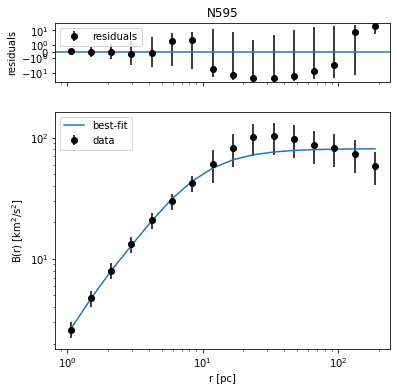

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 16
    # variables        = 5
    chi-square         = 4.62559205
    reduced chi-square = 0.42050837
    Akaike info crit   = -9.85574957
    Bayesian info crit = -5.99280596
[[Variables]]
    r0:     7.86416495 +/- 0.87394264 (11.11%) (init = 8.780435)
    sig2:   39.6229946 +/- 3.22393817 (8.14%) (init = 44.12787)
    m:      1.87403141 +/- 0.16188839 (8.64%) (init = 1.5)
    s0:     0.59243135 +/- 0.21577668 (36.42%) (init = 1.556345)
    noise:  1.83621482 +/- 0.95088121 (51.78%) (init = 2.706261)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  0.925
    C(r0, sig2)    =  0.764
    C(r0, m)       = -0.750
    C(sig2, m)     = -0.474
    C(r0, s0)      =  0.298
    C(m, noise)    =  0.206
    C(r0, noise)   =  0.164
    C(sig2, noise) = -0.138


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=1.705064865571238e-07 < 1e-05 at iteration 8 and prob(s0=0.1184862697542326) = 0.5906107653415669 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.6003010134988496 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -2.48193  -1.57203  -0.78254   7.86416  +0.91769  +2.25123  +5.02594
 sig2 : -11.40104  -6.81981  -3.21632  39.62299  +3.30490  +7.93657 +13.55711
 m    :  -0.63810  -0.33668  -0.15291   1.87403  +0.16460  +0.37447  +0.69813
 s0   :      -inf      -inf      -inf   0.59243  +0.15467  +0.32676  +0.58030
 noise:      -inf      -inf      -inf   1.83621  +0.58867  +1.05800  +1.57561


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 7.1064746379852295 seconds ---
